# Physics Informed NODEs for EHBE temperature predictions

## Import the required libraries

In [2]:
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from typing import Callable, Union, Literal, Optional, List
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
import pandas as pd


## Helper functions to create a masked MLP

In [3]:
def CreateConnectivity(num_zones=None, num_hidden=None):
    """
    Generate sparse connection indices for a masked neural network.

    Creates three distinct sets of connections to define structured sparsity.

    Args:
        num_zones (int): Number of thermal zones.
        num_hidden (int): Number of hidden units per zone.

    Returns:
        Tuple[jax.Array, jax.Array, jax.Array]: Three 2xN arrays containing (row_indices, column_indices)
        for the three different sets of connections.
    """
    # Create connections1
    row_part1 = jnp.repeat(jnp.arange(num_zones), num_hidden)[None, :]
    row_part2 = jnp.arange(num_zones, num_zones*2 + 2)[None, :]
    row = jnp.concatenate([row_part1, row_part2], axis=1).astype(jnp.int32)
    
    col_part1 = jnp.tile(jnp.arange(num_hidden), (1, num_zones))
    col_part2 = jnp.arange(num_hidden, num_hidden + num_zones + 2)[None, :]
    col = jnp.concatenate([col_part1, col_part2], axis=1).astype(jnp.int32)
    
    connections1 = jnp.concatenate([row, col], axis=0)

    # Create connections2
    row_part1 = jnp.repeat(jnp.arange(num_hidden), num_zones*num_hidden)[None, :]
    row_part2 = jnp.repeat(jnp.arange(num_hidden, num_hidden + num_zones), num_hidden)[None, :]
    row_part3 = jnp.repeat(jnp.arange(num_hidden + num_zones, num_hidden + num_zones + 2), 
                          num_hidden*num_zones)[None, :]
    row = jnp.concatenate([row_part1, row_part2, row_part3], axis=1).astype(jnp.int32)
    
    col = jnp.tile(jnp.arange(num_zones*num_hidden)[None, :], (1, num_hidden + 3))
    connections2 = jnp.concatenate([row, col], axis=0).astype(jnp.int32)

    # Create connections3
    row_conn3 = jnp.arange(num_zones*num_hidden)[None, :]
    col_conn3 = jnp.repeat(jnp.arange(num_zones), num_hidden)[None, :]
    connections3 = jnp.concatenate([row_conn3, col_conn3], axis=0).astype(jnp.int32)

    return connections1, connections2, connections3

def create_mask_from_connections(connections):
    """
    Create a binary mask matrix from a set of connection indices.

    This function constructs a mask used to zero out non-connected weights in a
    neural network layer, based on the specified (input, output) index pairs.

    Args:
        connections (jax.Array): A 2xN array where the first row contains source indices (rows),
                                 and the second row contains target indices (columns).

    Returns:
        jax.Array: A binary 2D mask of shape (out_features, in_features), where 1 indicates
                   a valid connection and 0 indicates no connection.
    """
    in_features = jnp.max(connections[0]) + 1  # Input layer size
    out_features = jnp.max(connections[1]) + 1  # Output layer size

    # Initialize a mask of zeros
    mask = jnp.zeros((out_features, in_features))

    # Set 1s where connections exist
    row_idx, col_idx = connections  # Extract row and column indices
    mask = mask.at[col_idx, row_idx].set(1)

    return mask


class MaskedMLP(eqx.Module):
    """
    A masked multilayer perceptron (MLP) with structured sparsity.

    Each linear layer in the network applies a binary mask to its weights to enforce
    a predefined sparsity pattern. Built using Equinox and compatible with JAX transformations.

    Attributes:
        layers (tuple): Sequence of linear layers.
        masks (tuple): Binary masks applied to weights of each layer.
        activation (Callable): Activation function for hidden layers.
        final_activation (Callable): Activation function for the output layer.
        use_bias (bool): Whether to include bias terms in hidden layers.
        use_final_bias (bool): Whether to include a bias term in the final layer.
        in_size (int or 'scalar'): Dimensionality of the input.
        out_size (int or 'scalar'): Dimensionality of the output.
        hidden_sizes (List[int]): Sizes of hidden layers.
        depth (int): Number of hidden layers.
    """
    layers: tuple
    masks: tuple = eqx.field(static=True)
    activation: Callable
    final_activation: Callable
    use_bias: bool = eqx.field(static=True)
    use_final_bias: bool = eqx.field(static=True)
    in_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    out_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    hidden_sizes: List[int] = eqx.field(static=True)
    depth: int = eqx.field(static=True)

    def __init__(
        self,
        in_size: Union[int, Literal["scalar"]],
        out_size: Union[int, Literal["scalar"]],
        hidden_sizes: List[int],
        masks: list,
        activation: Callable = jax.nn.soft_sign,
        final_activation: Callable = lambda x: x,
        use_bias: bool = True,
        use_final_bias: bool = True,
        *,
        key: jax.random.PRNGKey,
        **kwargs,
    ):
        super().__init__(**kwargs)
        depth = len(hidden_sizes)
        keys = jax.random.split(key, depth + 1)
        layers = []
        
        # Input layer
        layers.append(eqx.nn.Linear(in_size, hidden_sizes[0], use_bias, key=keys[0]))
        
        # Hidden layers
        for i in range(depth - 1):
            layers.append(eqx.nn.Linear(hidden_sizes[i], hidden_sizes[i + 1], use_bias, key=keys[i + 1]))
        
        # Output layer
        layers.append(eqx.nn.Linear(hidden_sizes[-1], out_size, use_final_bias, key=keys[-1]))
        
        self.layers = tuple(layers)
        self.masks = tuple(jnp.array(m) for m in masks)
        self.in_size = in_size
        self.out_size = out_size
        self.hidden_sizes = hidden_sizes
        self.depth = depth
        self.activation = activation
        self.final_activation = final_activation
        self.use_bias = use_bias
        self.use_final_bias = use_final_bias
    
    @jax.named_scope("eqx.nn.MaskedMLP")
    def __call__(self, x: jax.Array, *, key: Optional[jax.random.PRNGKey] = None) -> jax.Array:
        for layer, mask in zip(self.layers[:-1], self.masks[:-1]):
            weight_masked = layer.weight * mask
            x = (weight_masked @ x) + (layer.bias if self.use_bias else 0)
            x = self.activation(x)
        
        weight_masked = self.layers[-1].weight * self.masks[-1]
        x = (weight_masked @ x) + (self.layers[-1].bias if self.use_final_bias else 0)
        x = self.final_activation(x)
        
        return x

Masked MLPs of the `MaskedMLP` class have a sparse stucture that blocks the interference of adjacent zone heating $Q_j$ on the temperature rate of change of another zone $\frac{T_i}{dt}$.

<div style="text-align: center;">
<img src="NN_Archi_revised_190mm_1000DPI_test.png" alt="NN Architecture" width="50%" height="50%">

## NODE model structure

In [4]:
class Func(eqx.Module):
    """
    Function module for use in Neural ODEs, either using a MaskedMLP or a standard MLP.

    This class wraps an MLP (either masked or unmasked) and evaluates it on concatenated
    inputs, typically the system state and interpolated exogenous inputs.

    Attributes:
        mmlp (Callable): A MaskedMLP or standard Equinox MLP used for function approximation.
    """
    mmlp: None

    def __init__(
        self,
        in_size: Union[int, Literal["scalar"]],
        out_size: Union[int, Literal["scalar"]],
        hidden_sizes: List[int],
        masks: list,
        mmlp_flag: bool = True,
        *,
        key: jax.random.PRNGKey,
        **kwargs,
        ):
        
        super().__init__(**kwargs)

        if mmlp_flag:
            self.mmlp = MaskedMLP(
            in_size = in_size, 
            out_size = out_size, 
            hidden_sizes = hidden_sizes, 
            masks = masks, 
            key = key
            )
        else:
            self.mmlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=24,
            depth=2,
            activation=jnn.soft_sign,
            key=key,
            )

    def __call__(self, t, y, args):
        ts, us = args
        _ts, _us = diffrax.rectilinear_interpolation(ts, us)
        interpolator = diffrax.LinearInterpolation( _ts, _us)
    
        return self.mmlp(jnp.concatenate([y, jnp.atleast_1d(interpolator.evaluate(t))]))


class NeuralODE(eqx.Module):
    """
    Neural Ordinary Differential Equation module.

    Wraps the differential equation solver to model system dynamics
    using a neural network (either masked or unmasked) as the derivative function.

    Attributes:
        func (Func): Callable differential function approximator.
    """
    func: Func

    def __init__(self, in_size, out_size, hidden_sizes, masks, mmlp_flag, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(in_size, out_size, hidden_sizes, masks, mmlp_flag, key=key)

    def __call__(self, ts, y0, args):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=(ts[1] - ts[0])/2,
            y0=y0,
            args=(ts, args),
            stepsize_controller=diffrax.ConstantStepSize(),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

## Helper functions

In [5]:
def split_sequence_data(data, split_ratio):
    nsim = len(data)

    dev_start = math.ceil(split_ratio[0] * nsim / 100.)
    test_start = dev_start + math.ceil(split_ratio[1] * nsim / 100.)
    train_slice = slice(0, dev_start)
    dev_slice = slice(dev_start, test_start)
    test_slice = slice(test_start, nsim)


    train_data = data[train_slice]
    dev_data = data[dev_slice]
    test_data = data[test_slice]

    return train_data, dev_data, test_data

def create_sliding_windows(data, window_size=24):
    return jnp.stack([data[i:i + window_size] for i in range(len(data) - window_size + 1)])

def return_scalers(split_ratio = [62.5, 12.5]):
    df_data = pd.read_csv('house_data.csv')
    df_data = df_data[:-1]
    time_array = np.column_stack((df_data['Time']))
    timestamps = df_data.pop('Time')

    _ts = jnp.array([x for x in range(0,df_data.shape[0])])

    ts = jnp.linspace(0., 23., 24)

    temp_names = [f'T0{i}_TEMP' for i in range(1,10)]

    u_array = jnp.column_stack((df_data.loc[:, ~df_data.columns.isin(temp_names)].copy().values)).T
    u_array = jnp.hstack([u_array[:, 1:], u_array[:, :1]])

    u_scaler = MinMaxScaler(feature_range=(0, 1))
    u_scaler.fit(u_array[:int(-(len(u_array)*(1-split_ratio[0]/100)+1))])
    

    x_array = jnp.column_stack((df_data[temp_names].values)).T

    x_scaler = MinMaxScaler(feature_range=(0, 1))
    x_scaler.fit(x_array[:int(-(len(x_array)*(1-split_ratio[0]/100)+1))])


    return x_scaler, u_scaler

def dataloader(arrays, batch_size, *, key):

    dataset_size = arrays[0].shape[0]

    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

## Prepare and preprocess the data
The predicted variables $(X)$ and exogenous variables $(U)$ are stacked in two different Jax.NumPy arrays and then normalized scaled between 0 and 1 (a good practice when manipulating NODEs). Note that all the data is normalized using only the 10 days training data. This is to avoid soiling the validation and both training sets with prior knowledge bias.

In [6]:
def get_data(time_horizon = 24, split_ratio = [62.5, 12.5]):
    """
    Load, normalize, and prepare time-series data for training a neural ODE.

    This function performs the following:
    - Loads `house_data.csv`, splitting into temperature (state) and non-temperature (control) variables.
    - Applies Min-Max normalization to both inputs and outputs.
    - Splits data into training, validation, and test sets based on the split ratio.
    - Generates sliding windows of data for time-series modeling.

    Args:
        time_horizon (int): Size of the time window for creating sequences. Default is 24.
        split_ratio (List[float]): Ratio of train and validation splits in percent. 
                                   The test set gets the remaining data.
                                   Example: [62.5, 12.5] = 62.5% train, 12.5% val, 25% test.

    Returns:
        Tuple:
            - ts (jax.Array): Array of normalized time steps over one horizon.
            - X (Tuple[jax.Array, jax.Array, jax.Array]): Temperature sequences (train, val, test).
            - U (Tuple[jax.Array, jax.Array, jax.Array]): Exogenous variables sequences (train, val, test).
            - scalers (Tuple[MinMaxScaler, MinMaxScaler]): Fitted scalers.
    """
    df_data = pd.read_csv('house_data.csv')
    df_data = df_data[:-1]
    time_array = np.column_stack((df_data['Time']))
    timestamps = df_data.pop('Time')

    _ts = jnp.array([x for x in range(0,df_data.shape[0])])

    ts = jnp.linspace(0., 23., 24)

    temp_names = [f'T0{i}_TEMP' for i in range(1,10)]

    u_array = jnp.column_stack((df_data.loc[:, ~df_data.columns.isin(temp_names)].copy().values)).T
    u_array = jnp.hstack([u_array[:, 1:], u_array[:, :1]])

    u_scaler = MinMaxScaler(feature_range=(0, 1))
    u_scaler.fit(u_array[:int(-(len(u_array)*(1-split_ratio[0]/100)+1))])
    

    scaled_u_array = u_scaler.transform(u_array)

    x_array = jnp.column_stack((df_data[temp_names].values)).T

    x_scaler = MinMaxScaler(feature_range=(0, 1))
    x_scaler.fit(x_array[:int(-(len(x_array)*(1-split_ratio[0]/100)+1))])

    scaled_x_array = x_scaler.transform(x_array)


    x_train_data, x_val_data, x_test_data = split_sequence_data(data = scaled_x_array,  split_ratio = split_ratio)
    u_train_data, u_val_data, u_test_data = split_sequence_data(data = scaled_u_array,  split_ratio = split_ratio)

    x_train_data = create_sliding_windows(x_train_data, window_size=time_horizon)
    x_val_data = create_sliding_windows(x_val_data, window_size=time_horizon)
    x_test_data = create_sliding_windows(x_test_data, window_size=time_horizon)

    u_train_data = create_sliding_windows(u_train_data, window_size=time_horizon)
    u_val_data = create_sliding_windows(u_val_data, window_size=time_horizon)
    u_test_data = create_sliding_windows(u_test_data, window_size=time_horizon)

    X = x_train_data,x_val_data,x_test_data
    U = u_train_data,u_val_data,u_test_data

    scalers = (x_scaler, u_scaler)


    return ts, X, U, scalers

## Training the model

In [7]:
def main(
    batch_size=24,
    lr_strategy=(0.02,),
    steps_strategy=(2000,),
    length_strategy=(1,),
    in_size = 20, 
    out_size = 9,
    mmlp_flag = True,
    seed=5789,
    print_every=100,
    dry_run=True,
):
    
    """
    Train a NeuralODE model using either a MaskedMLP or standard MLP backbone.

    The function:
    - Loads and preprocesses time-series data.
    - Initializes a masked or unmasked NeuralODE model.
    - Creates custom masks for structured weight sparsity.
    - Trains the model using multiple strategy configurations (learning rate, steps, sequence length).
    - Tracks training and validation loss.
    - Saves the best-performing model based on validation loss.

    Args:
        batch_size (int): Number of sequences per training batch.
        lr_strategy (tuple): Tuple of learning rates for strategy scheduling.
        steps_strategy (tuple): Number of training steps per learning rate strategy.
        length_strategy (tuple): Sequence length fractions to use per strategy stage.
        in_size (int): Input size of the model (e.g., number of control variables).
        out_size (int): Output size of the model (e.g., number of state variables).
        mmlp_flag (bool): If True, use MaskedMLP; otherwise use standard MLP.
        seed (int): Random seed for reproducibility.
        print_every (int): Interval at which to log training progress.
        dry_run (bool): If True, skip training.

    Returns:
        Tuple:
            - model (NeuralODE): The trained model.
            - loss_vector (list): Training loss at each step.
            - val_loss_vector (list): Validation loss at each step.
    """
    if dry_run:
        print("Dry run mode: skipping training.")
        return None, [], []
    
    best_model_path = fr'best_model_Masked_Conn_{mmlp_flag}.eqx'
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)

    loss_vector, val_loss_vector = [], []
    best_val_loss = float('inf')

    ts, X, U, scalers = get_data()
    ys = X[0]
    us = U[0]


    ys_val = X[1]
    us_val = U[1]

    x_scaler = scalers[0]

    _, length_size, data_size = ys.shape

    (con1, con2, con3) = CreateConnectivity(num_zones=data_size, num_hidden=17)
    mask1 = create_mask_from_connections(con1)
    mask2 = create_mask_from_connections(con2)
    mask3 = create_mask_from_connections(con3)

    masks = [mask1, mask2, mask3]


    model = NeuralODE(in_size = in_size, out_size = out_size,
                       hidden_sizes = [mask1.shape[0], mask2.shape[0]], 
                       masks = masks, mmlp_flag = mmlp_flag, key=model_key)


    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi, ui):
        y_pred = jax.vmap(model, in_axes=(None, 0, 0))(ti, yi[:, 0, 0:9], ui[:, :, :])

        return 10.*jnp.mean((yi - y_pred) ** 2)


    @eqx.filter_jit
    def make_step(ti, yi, ui, model, opt_state):
        loss, grads = grad_loss(model, ti, yi, ui)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adam(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        _us = us[:, : int(length_size * length)]
        for step, (yi,), (ui,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key), dataloader((_us,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, ui, model, opt_state)
            loss_vector.append(loss)

            val_loss, _ = grad_loss(model, ts, ys_val, us_val)
            val_loss_vector.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                eqx.tree_serialise_leaves(best_model_path, model)
                print(f"New best validation loss: {best_val_loss}. Model saved to {best_model_path}.")

            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    return model, loss_vector, val_loss_vector

In [8]:
model, loss_vector, val_loss_vector = main()

Dry run mode: skipping training.


## Model Inference and Reconstruction

We perform inference using two trained models, one **standard MLP-based** and one **MaskedMLP-based**, to simulate temperature predictions over time: 

1. **Model Initialization & Deserialization**  
   Two `NeuralODE` models are instantiated:
   - `model_full`: A standard MLP-based model (`mmlp_flag=False`).
   - `model_masked`: A MaskedMLP-based model (`mmlp_flag=True`).  
   Each model is loaded with pretrained weights from disk using `eqx.tree_deserialise_leaves`.

2. **Inference Loop**  
   For each time series in the train, validation, and test sets:
   - The model (`model_masked`) is used to predict temperature trajectories.
   - Both predicted and ground-truth trajectories are stored for comparison.

3. **DataFrame Construction**  
   A `DataFrame` (`xn_df`) is built to organize predicted and actual temperatures:
   - Columns follow the format: `T_i_Real` and `T_i_NODE`, for each zone `i`.



In [9]:
key = jr.PRNGKey(5678)
data_key, model_key, loader_key = jr.split(key, 3)
mmlp_flag = False

__ts, __X, __U, _ = get_data()

_, length_size, data_size = __X[0].shape

(con1, con2, con3) = CreateConnectivity(num_zones=data_size, num_hidden=17)
mask1 = create_mask_from_connections(con1)
mask2 = create_mask_from_connections(con2)
mask3 = create_mask_from_connections(con3)

masks = [mask1, mask2, mask3]

model_full = NeuralODE(in_size = 20, out_size = 9,
                    hidden_sizes = [mask1.shape[0], mask2.shape[0]],
                    masks = masks, mmlp_flag = False, key=model_key)
model_full = eqx.tree_deserialise_leaves(r'best_model_Masked_Conn_False.eqx', model_full)


model_masked = NeuralODE(in_size = 20, out_size = 9,
                    hidden_sizes = [mask1.shape[0], mask2.shape[0]],
                    masks = masks, mmlp_flag = True, key=model_key)
model_masked = eqx.tree_deserialise_leaves(r'best_model_Masked_Conn_True.eqx', model_masked)


ys_train, ys_val, ys_test = __X
us_train, us_val, us_test = __U


temp_ys_pred = []
temp_ys_real = []
x_scaler, u_scaler = return_scalers()

ys = np.vstack((ys_train, ys_val, ys_test))
us = np.vstack((us_train, us_val, us_test))

for i in range(0, ys_train.shape[0]):
    model_y_train = model_masked(__ts, ys_train[i, 0, :], us_train[i, :, :])
    temp_ys_pred.append(model_y_train)
    temp_ys_real.append(ys_train[i, :, :])


for i in range(0, ys_val.shape[0]):
    model_y_val = model_masked(__ts, ys_val[i, 0, :], us_val[i, :, :])
    temp_ys_pred.append(model_y_val)
    temp_ys_real.append(ys_val[i, :, :])


for i in range(0, ys_test.shape[0]):
    model_y_test = model_masked(__ts, ys_test[i, 0, :], us_test[i, :, :])
    temp_ys_pred.append(model_y_test)
    temp_ys_real.append(ys_test[i, :, :])

raw_xn = np.vstack(temp_ys_real)
pred_xn = np.vstack(temp_ys_pred)

raw_xn = x_scaler.inverse_transform(raw_xn)
pred_xn = x_scaler.inverse_transform(pred_xn)


xn_df = pd.DataFrame()

for i in range(1,raw_xn.shape[1]+1):  
    xn_df[f'T_{i}_Real'] = raw_xn[:,i-1]
    xn_df[f'T_{i}_NODE'] = pred_xn[:,i-1]


measured_Real = xn_df.iloc[::24].copy().reset_index(drop=True)



c:\Users\14506\anaconda3\envs\diffrax\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\14506\anaconda3\envs\diffrax\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\14506\anaconda3\envs\diffrax\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


## Visualizing results

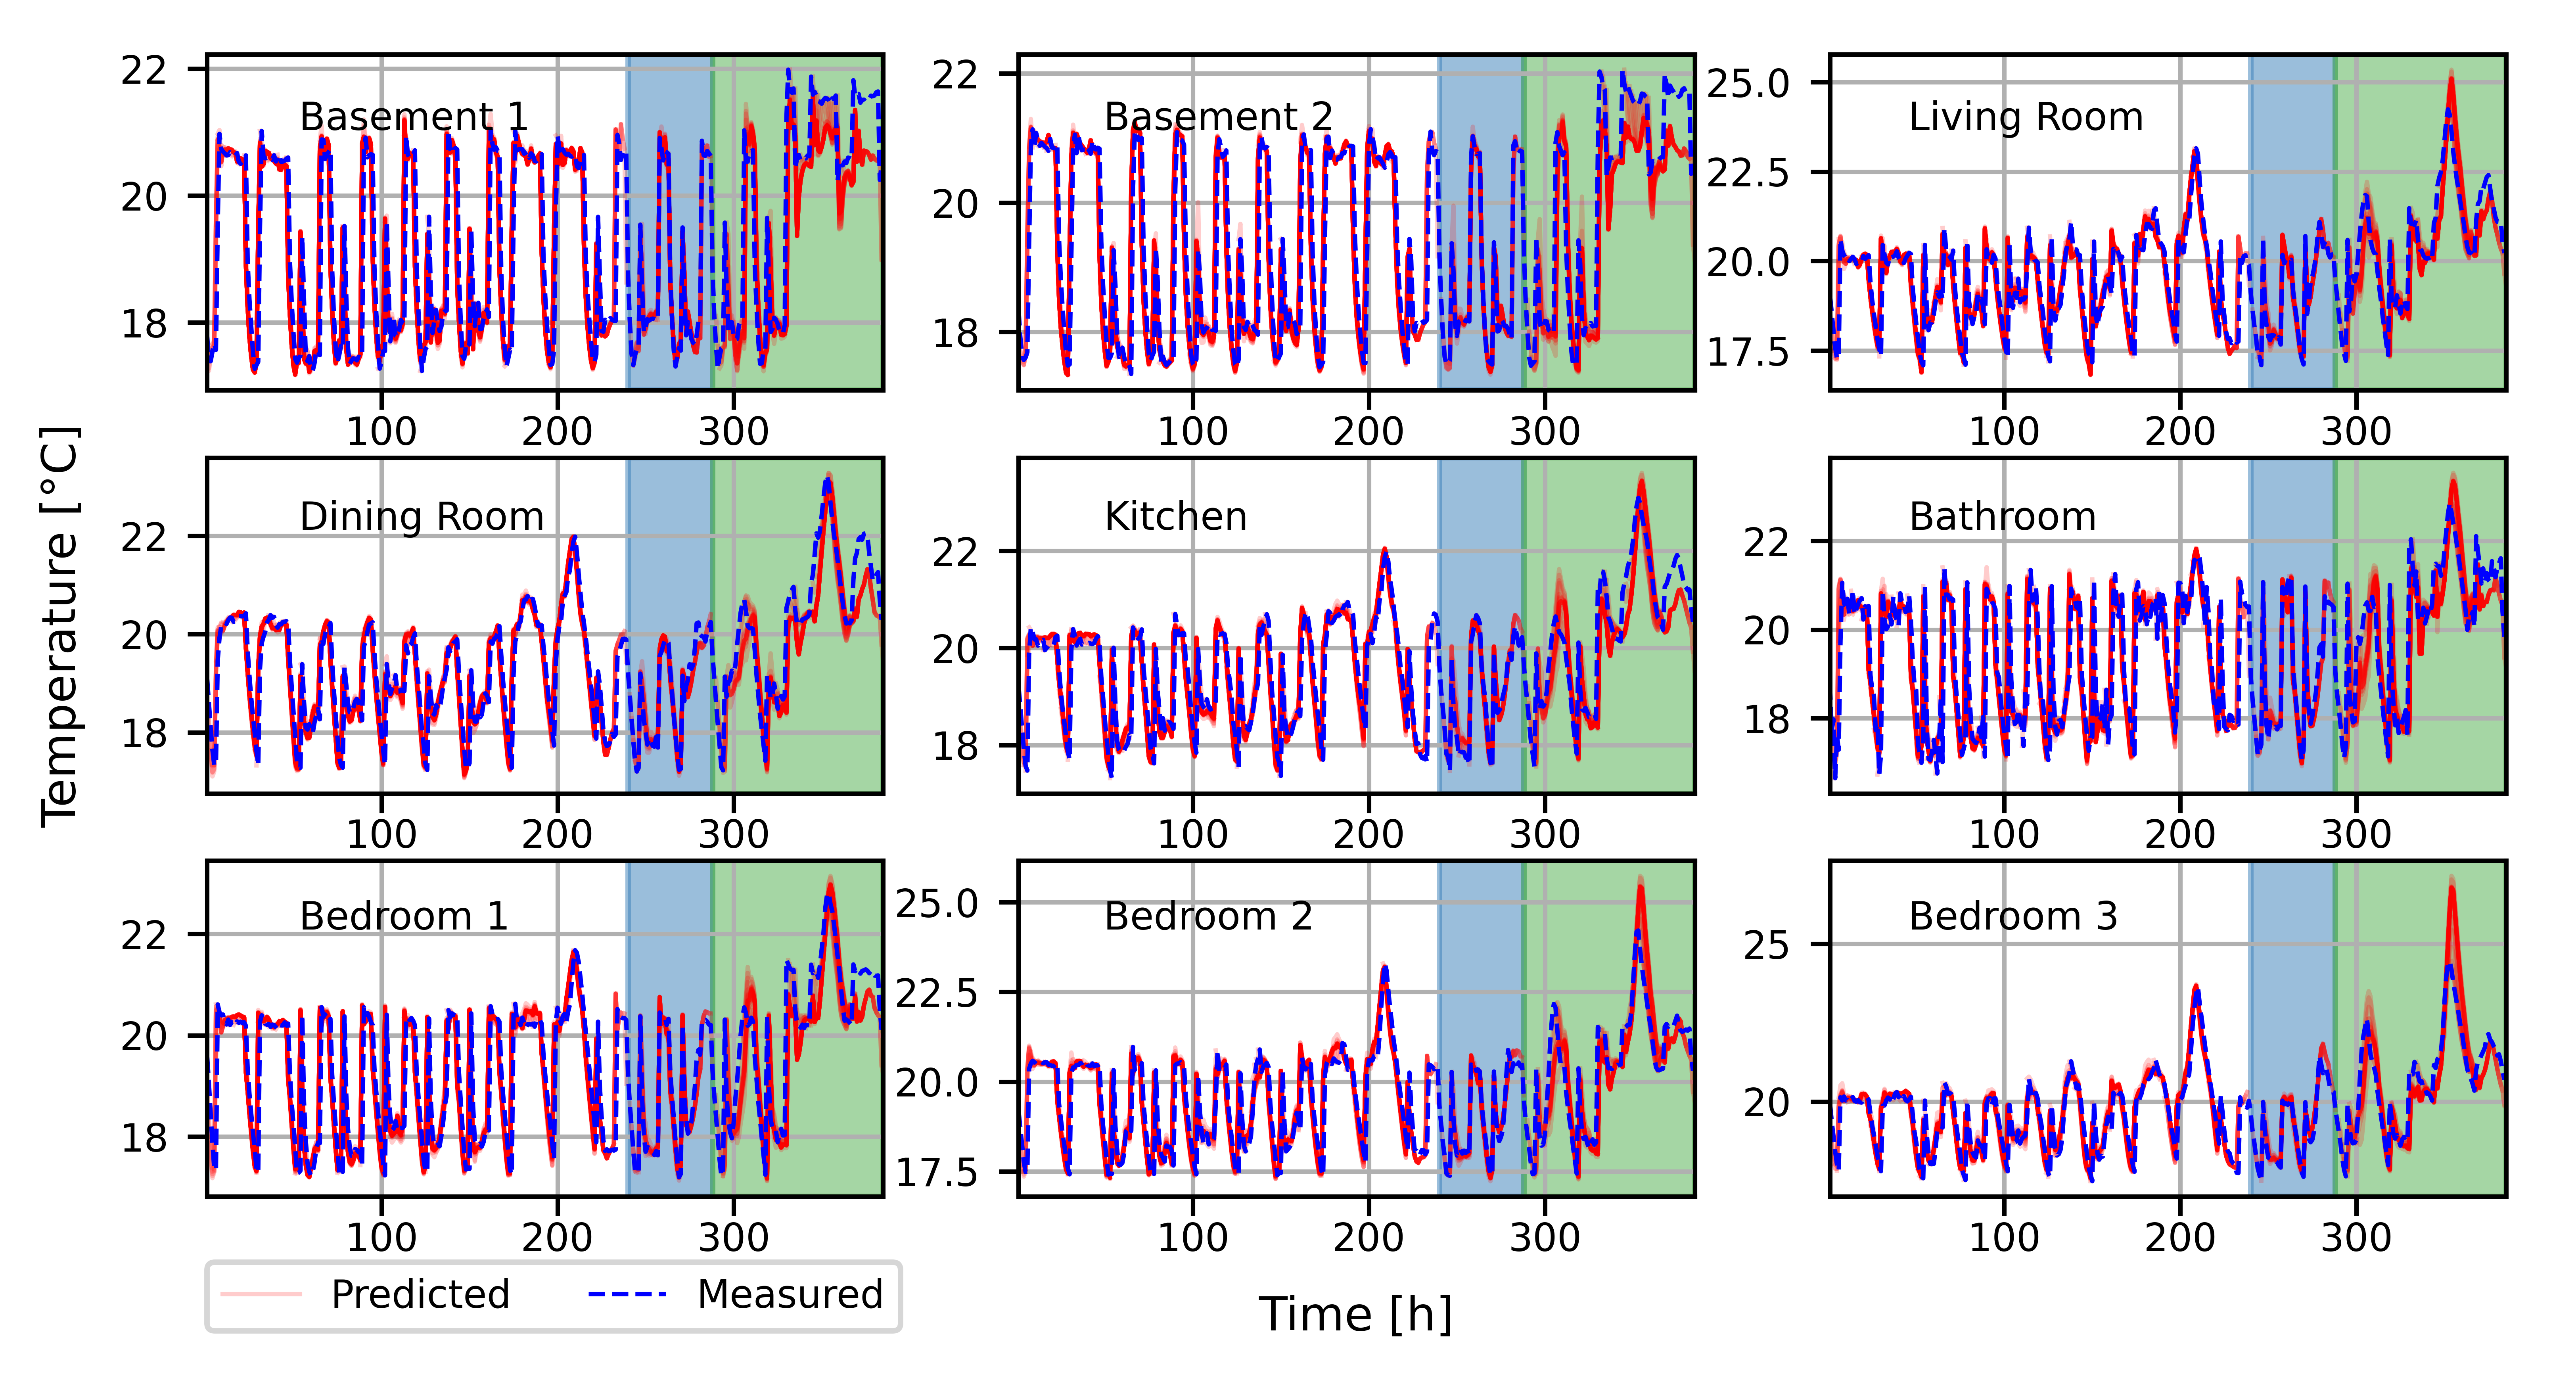

In [10]:
df_data = pd.read_csv('house_data.csv')
df_data = df_data[:-1]
time_array = np.column_stack((df_data['Time']))
timestamps = df_data.pop('Time')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000

BIGGER_SIZE = 7
BIGGEST_SIZE = 8.5


plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(190/25.4,190/25.4/2))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)


ax_dict = {'ax1' : ax1,
           'ax2' : ax2,
           'ax3' : ax3,
           'ax4' : ax4,
           'ax5' : ax5,
           'ax6' : ax6,
           'ax7' : ax7,
           'ax8' : ax8,
           'ax9' : ax9,
            }

names_arr = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Time [h]')
ax.set_ylabel('Temperature [°C]')

for i in range(1,10):
    k = 0
    for j in range(0,len(measured_Real)):
        if (j == 217) or (j==217+25):
            k += 1
        shift = k*24
        if j+i == 1:
            ax_dict[f'ax{i}'].plot(range(j+shift,j+24+shift),xn_df[f'T_{i}_NODE'][j*24:(j+1)*24],color='red',alpha=0.2,label=f'Predicted',linewidth=.8)
        else:
            ax_dict[f'ax{i}'].plot(range(j+shift,j+24+shift),xn_df[f'T_{i}_NODE'][j*24:(j+1)*24],color='red',alpha=0.2,linewidth=.8)
    ax_dict[f'ax{i}'].plot(range(1,385), df_data[f'T0{i}_TEMP'],'--',color='blue',label=f'Measured',linewidth=.8)

    ax_dict[f'ax{i}'].grid()
    ax_dict[f'ax{i}'].set_xlim(1,385)
    ax_dict[f'ax{i}'].text(0.04+0.35*((i-1)%3), 0.96-0.35*((i-1)//3), names_arr[i-1], transform=ax.transAxes, fontsize=BIGGER_SIZE, verticalalignment='top',)
    ax_dict[f'ax{i}'].axvspan(240,288,color='#377eb8',alpha=0.5)
    ax_dict[f'ax{i}'].axvspan(288,385,color='#4daf4a',alpha=0.5)
    
    ax_dict[f'ax{i}'].xaxis.set_tick_params(pad=1)


    if i == 1:    
        ax_dict[f'ax{i}'].legend(ncols=2,loc=[0,0],bbox_to_anchor=[0,-2.8])
